# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl

rm: cannot remove 'dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl': No such file or directory


In [3]:

class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))



paths = {}
keys = train_paths.keys()
for key in list(keys)[0:1]:
    paths.update({key: train_paths[key]})
train_paths = paths

print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)


{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}}
----------------------------------------------------------------------------------------
{'20151224': {'y': 'dataset/Kyoto2016/2015/12/20151224_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151224_x.csv'}, '20151204': {'y': 'dataset/Kyoto2016/2015/12/20151204_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151204_x.csv'}, '20151216': {'x': 'dataset/Kyoto2016/2015/12/20151216_x.csv', 'y': 'dataset/Kyoto2016/2015/12/20151216_y.csv'}, '20151222': {'x': 'dataset/Kyoto2016/2015/12/20151222_x.csv', 'y': 'dataset/Kyoto2016/2015/12/20151222_y.csv'}, '20151214': {'x': 'dataset/Kyoto2016/2015/12/20151214_x.csv', 'y': 'dataset/Kyoto2016/2015/12/20151214_y.csv'}, '20151202': {'x': 'dataset/Kyoto2016/2015/12/20151202_x.csv', 'y': 'dataset/Kyoto2016/2015/12/20151202_y.csv'}, '20151227': {'y': 'dataset/Kyoto2016/2015/12/20151227_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151227_x.csv'}, '20151203': {

In [4]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell
from sklearn import model_selection as ms
from sklearn import metrics as me

In [5]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 40

    hidden_decoder_dim = 42
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [6]:
import collections

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'quality_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                      feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                 net.y_input_: y_train[i,np.newaxis,:], 
                                                                 net.keep_prob:1, net.lr:lr})
                            #summary_writer_train.add_summary(summary_str, epoch)
                            if(train_loss > 1e9):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                        valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                              feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                         net.y_input_: y_valid[:,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)

                        
                    end_time = time.perf_counter() 
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x_input: x_test[:,np.newaxis,:], 
                                                                                         net.y_input_: y_test[:,np.newaxis,:], 
                                                                                         net.keep_prob:1, net.lr:lr})

                        quality_score = me.matthews_corrcoef(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        accuracy = me.roc_auc_score(actual_value, pred_value)
                        
                        print("Key {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, quality_score: {}, recall: {}, prec: {}".format(key, train_loss, valid_accuracy, accuracy, quality_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                                    Train.best_acc_global = accuracy
                                    Train.pred_value = pred_value
                                    Train.actual_value = actual_value

                                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):
                                                  (curr_pred, 
                                                   Train.result(key, f, h,valid_accuracy, accuracy, quality_score, end_time - start_time))})



            

In [7]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3]

        epochs = [1]
        lrs = [1e-2] #[1e-2, 1e-2/2, 1e-2/4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")

        past_scores.append(df_results).to_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")


In [8]:
#%%timeit -r 1
Hyperparameters.start_training()

Current Layer Attributes - epochs:1 hidden layers:1 features count:1
Key 20151224 | Training Loss: 0.003847 | Train Accuracy: 0.999688 | Test Accuracy: 0.668208, quality_score: 0.24361090449302303, recall: 0.972579078569002, prec: 0.9887394508354209
Key 20151204 | Training Loss: 0.003847 | Train Accuracy: 0.999688 | Test Accuracy: 0.670322, quality_score: 0.2537754215311179, recall: 0.9803740115331715, prec: 0.9913141439643025
Key 20151216 | Training Loss: 0.003847 | Train Accuracy: 0.999688 | Test Accuracy: 0.680021, quality_score: 0.5022422043836925, recall: 0.996858291466295, prec: 0.9863768193066014
Key 20151222 | Training Loss: 0.003847 | Train Accuracy: 0.999688 | Test Accuracy: 0.619577, quality_score: 0.1239461546796079, recall: 0.9518292615347104, prec: 0.9900398100185985
Key 20151214 | Training Loss: 0.003847 | Train Accuracy: 0.999688 | Test Accuracy: 0.854176, quality_score: 0.839108427156579, recall: 0.999983033377588, prec: 0.9955701387657199
Key 20151202 | Training Loss:

Key 20151215 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151213 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151209 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151228 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151226 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151218 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151231 | Training Loss: 0.000650 | Train Accuracy: 1.000000 | Test Accuracy: 1.000000, quality_score: 1.0, recall: 1.0, prec: 1.0
Key 20151212 | Training Loss: 0.000650 | Train A

In [9]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [10]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [11]:
#pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
#df_results.to_pickle("dataset/tf_lstm_nsl_kdd_scores.pkl")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [13]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")

In [14]:
past_scores.sort_values(by='quality_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,quality_score,time_taken
61,20151230,1,3,1.000000,1.000000,1.000000,9.201964
40,20151205,1,3,1.000000,1.000000,1.000000,9.201964
60,20151220,1,3,1.000000,1.000000,1.000000,9.201964
59,20151201,1,3,1.000000,1.000000,1.000000,9.201964
58,20151221,1,3,1.000000,1.000000,1.000000,9.201964
57,20151211,1,3,1.000000,1.000000,1.000000,9.201964
56,20151212,1,3,1.000000,1.000000,1.000000,9.201964
55,20151231,1,3,1.000000,1.000000,1.000000,9.201964
46,20151210,1,3,1.000000,1.000000,1.000000,9.201964
53,20151226,1,3,1.000000,1.000000,1.000000,9.201964


In [15]:
psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='quality_score', ascending=False)

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151230     1.000000    1.000000   
               1              20151214     0.999688    0.854176   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                   1.000000    9.201964  
               1                   0.839108    6.222824

In [16]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")

In [17]:
df = Train.predictions['20151228_1_3'].dropna()

In [18]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

1.0

In [20]:
df.groupby(by="Actual").Actual.count()

Actual
0.0      4159
1.0    363423
Name: Actual, dtype: int64

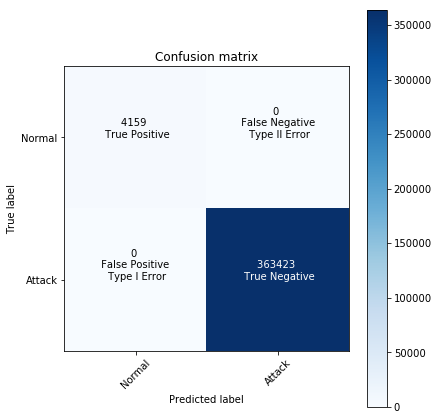

In [21]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [22]:
psg.mean().sort_values(by='quality_score', ascending=False)

train_score  test_score  quality_score  \
no_of_features hidden_layers                                           
1              3                 1.000000    0.999996       0.999827   
               1                 0.999688    0.709091       0.444852   

                              time_taken  
no_of_features hidden_layers              
1              3                9.201964  
               1                6.222824

In [23]:
psg.std()

train_score  test_score  quality_score  \
no_of_features hidden_layers                                           
1              1                      0.0    0.085877       0.215775   
               3                      0.0    0.000014       0.000586   

                              time_taken  
no_of_features hidden_layers              
1              1                     0.0  
               3                     0.0

In [24]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.quality_score.mean(), scale=x.quality_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1               1                (0.021939629542, 0.867764005685)
                3                 (0.998678615375, 1.00097597522)
dtype: object